# Selección de cripto activos para una cartera de inversión

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Práctico 4 - Aprendizaje No Supervisado

# Introducción

En finanzas, encontrar grupos de activos similares o regímenes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definición de reglas de compra/venta, etc. 

En este práctico aplicaremos métodos de aprendizaje no supervisado. Estas metodologías en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener información útil de nuestros datos.

Podemos destacar métodos como clustering y reducción de dimensionalidad. Algunas de las metodologías despliegan su máximo potencial cuando se dispone de grandes cantidades de datos (activos en nuestro caso).

# 📖 ¡Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas específicas de tiempo. Nuestro objetivo será encontrar activos con comportamiento similiar en término de sus retornos.

Para esta actividad seleccionen periodos en los cuales esté disponible la data de todos los activos. 

## Parte I 

Una forma sencilla de predecir el comportamiento de los activos sería suponer que todos siguen el mismo modelo de aprendizaje automático y crear este modelo global para predecir los rendimientos de todos los activos. Sin embargo, es posible que ellos reaccionen de manera diferente a un conjunto de indicadores técnicos. Una forma de resolver este problema es crear un modelo diferente para grupos de activos que se espera que se comporten de manera similar.

Evaluen los siguientes algoritmos de clusterización. 

- Mean Shift.
- k-means. 
- Clustering Jerárquico 

¿Qué activos forman parte de cada cluster? ¿Encuentran alguna relación dentro de cada grupo?

## Parte II 

- Usar la medida de distancia dynamic time warping para agrupar por k-means y comparar con lo obtenido con la métrica euclídea ([link](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3)). Comente los resultados.

## Opcional 

- Aplicar factores dinámicos para ver si las tasas de retorno se pueden resumir en uno o unos pocos constructos subyacentes ([link](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_dfm_coincident.html))

# Fecha de entrega

- __Versión preliminar: 12/9__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

In [3]:
import pandas as pd
import numpy as np
import math

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pylab import rcParams
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

from pandas import Series, DataFrame

import seaborn as sns
import os
import time
import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid

import xgboost as xgb

import talib as ta
import datetime as dt

import warnings
warnings.filterwarnings("ignore") 

In [4]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [5]:
df = pd.read_csv('../2tp_analisisYCuracion/Activos limpios con features - 2tp - Final.csv', index_col = 'Fecha')

In [6]:
df.head()

,open,high,low,close,volume,active,day,month,year,weekday,...,ADX200,STOCH_SLOWK,STOCH_SLOWD,MACD,SMA_5,SMA_15,SMA_ratio,SMA5_Volume,SMA15_Volume,SMA_Volume_Ratio
Fecha,,,,,,,,,,,,,,,,,,,,,
2019-01-01 03:00:00,0.34640,0.35368,0.34617,0.35073,5.565085e+06,XRPUSDT,1,1,2019,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,130.72000,134.00000,130.71000,133.36000,4.847789e+04,ETHUSDT,1,1,2019,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,2.52060,2.56000,2.52040,2.53830,4.744196e+05,EOSUSDT,1,1,2019,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,0.03988,0.04068,0.03985,0.04061,1.281178e+07,ADAUSDT,1,1,2019,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,29.73000,30.16000,29.57000,30.12000,1.034450e+04,LTCUSDT,1,1,2019,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'active', 'day', 'month',
       'year', 'weekday', 'profit', 'real_volume', 'EMA5', 'EMA15', 'EMA50',
       'EMA100', 'EMA200', 'RSI5', 'RSI15', 'RSI50', 'RSI100', 'RSI200',
       'ADX5', 'ADX15', 'ADX50', 'ADX100', 'ADX200', 'STOCH_SLOWK',
       'STOCH_SLOWD', 'MACD', 'SMA_5', 'SMA_15', 'SMA_ratio', 'SMA5_Volume',
       'SMA15_Volume', 'SMA_Volume_Ratio'],
      dtype='object')

In [8]:
df.drop(columns=['EMA5', 'EMA15', 'EMA50',
       'EMA100', 'EMA200', 'RSI5', 'RSI15', 'RSI50', 'RSI100', 'RSI200',
       'ADX5', 'ADX15', 'ADX50', 'ADX100', 'ADX200', 'STOCH_SLOWK',
       'STOCH_SLOWD', 'MACD', 'SMA_5', 'SMA_15', 'SMA_ratio', 'SMA5_Volume',
       'SMA15_Volume', 'SMA_Volume_Ratio'], inplace=True)

## Parte 0 - Feature Engineer

### Funciones

In [9]:
def _extract_close(data, active):
    values = None

    if isinstance(data, Series):
        values = data.values
    else:
        if "close" in data.columns:
            values = data[data['active'] == active]['close']

    if values is None:
        raise ValueError(
            "data must be Pandas Series or DataFrame with a 'last' or 'close' column")

    return values

In [10]:
def _extract_high(data, active):
    values = None

    if isinstance(data, Series):
        values = data.values
    else:
        if "high" in data.columns:
            values = data[data['active'] == active]['high']

    if values is None:
        raise ValueError(
            "data must be Pandas Series or DataFrame with a 'last' or 'close' column")

    return values

In [11]:
def _extract_low(data, active):
    values = None

    if isinstance(data, Series):
        values = data.values
    else:
        if "low" in data.columns:
            values = data[data['active'] == active]['low']

    if values is None:
        raise ValueError(
            "data must be Pandas Series or DataFrame with a 'last' or 'close' column")

    return values

In [12]:
def STOCHRSI(data, active):
    closing_prices = _extract_close(data, active)
    return ta.STOCHRSI(closing_prices) 

In [13]:
def EMA(data, period, active):
    closing_prices = _extract_close(data, active)
    return ta.EMA(closing_prices, period)

In [14]:
def RSI(data, period, active):
    closing_prices = _extract_close(data, active)
    return ta.RSI(closing_prices, period)

In [15]:
def ADX(data, period, active):
    closing_prices = _extract_close(data, active)
    high_prices = _extract_high(data, active)
    low_prices = _extract_low(data, active)
    return ta.ADX(high_prices, low_prices, closing_prices, period)

In [16]:
def MACD(data, active, fastperiod = 12, slowperiod = 26, signalperiod  = 9):
    closing_prices = _extract_close(data, active)
    return ta.MACD(closing_prices, fastperiod, slowperiod, signalperiod)[0]

In [17]:
def STOCH(data, active):
    closing_prices = _extract_close(data, active)
    high_prices = _extract_high(data, active)
    low_prices = _extract_low(data, active)
    return ta.STOCH(high_prices, low_prices, closing_prices)

In [18]:
def add_target_n_steps(data, periods):
    target = data.shift(-periods).apply(lambda x: x.iloc[0])['close']
    return target

In [19]:
def plot_cluster_tickers(current_cluster, symbols):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0] / 4)), 
        4, 
        figsize=(15, 3 * int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, row in enumerate(current_cluster):
        ax[index].plot(row)
        ax[index].set_title(symbols[index])
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

### Clusterization

In [20]:
df

,open,high,low,close,volume,active,day,month,year,weekday,profit,real_volume
Fecha,,,,,,,,,,,,
2019-01-01 03:00:00,0.34640,0.35368,0.34617,0.35073,5.565085e+06,XRPUSDT,1,1,2019,Tuesday,1.250000,1.951842e+06
2019-01-01 03:00:00,130.72000,134.00000,130.71000,133.36000,4.847789e+04,ETHUSDT,1,1,2019,Tuesday,2.019584,6.465012e+06
2019-01-01 03:00:00,2.52060,2.56000,2.52040,2.53830,4.744196e+05,EOSUSDT,1,1,2019,Tuesday,0.702214,1.204219e+06
2019-01-01 03:00:00,0.03988,0.04068,0.03985,0.04061,1.281178e+07,ADAUSDT,1,1,2019,Tuesday,1.830491,5.202864e+05
2019-01-01 03:00:00,29.73000,30.16000,29.57000,30.12000,1.034450e+04,LTCUSDT,1,1,2019,Tuesday,1.311806,3.115763e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02 11:00:00,30.09000,31.00000,29.91000,30.84000,2.099238e+05,AXSUSDT,2,5,2022,Monday,2.492522,6.474051e+06
2022-05-02 11:00:00,38711.87000,39155.47000,38242.51000,38840.00000,1.745554e+04,BTCUSDT,2,5,2022,Monday,0.330984,6.779730e+08
2022-05-02 11:00:00,2.07100,2.10900,2.03400,2.09400,3.760029e+06,EOSUSDT,2,5,2022,Monday,1.110575,7.873501e+06


In [21]:
scaler = MinMaxScaler()
i = 0
for active in set(df.active):
    df_aux = df[df.active == active]
    df_aux['close_scaled'] = scaler.fit_transform(df_aux['close'].values.reshape(-1, 1))
    df_aux['open_scaled'] = scaler.fit_transform(df_aux['open'].values.reshape(-1, 1))
    df_aux['high_scaled'] = scaler.fit_transform(df_aux['high'].values.reshape(-1, 1))
    df_aux['low_scaled'] = scaler.fit_transform(df_aux['low'].values.reshape(-1, 1))
    df_aux['volume_scaled'] = scaler.fit_transform(df_aux['volume'].values.reshape(-1, 1))
    if i == 0:
        df_final_scaled = df_aux.copy()
        i += 1
    else:
        df_final_scaled = pd.concat([df_final_scaled, df_aux])

df_final_scaled

,open,high,low,close,volume,active,day,month,year,weekday,profit,real_volume,close_scaled,open_scaled,high_scaled,low_scaled,volume_scaled
Fecha,,,,,,,,,,,,,,,,,
2019-01-01 03:00:00,29.73,30.16,29.57,30.12,10344.49821,LTCUSDT,1,1,2019,Tuesday,1.311806,3.115763e+05,0.002181,0.001156,0.000626,0.014980,0.001164
2019-01-01 07:00:00,30.14,30.67,30.13,30.34,8793.09194,LTCUSDT,1,1,2019,Tuesday,0.663570,2.667824e+05,0.002759,0.002234,0.001955,0.016486,0.000783
2019-01-01 11:00:00,30.35,30.79,30.24,30.29,20755.11106,LTCUSDT,1,1,2019,Tuesday,-0.197694,6.286723e+05,0.002628,0.002786,0.002268,0.016781,0.003719
2019-01-01 15:00:00,30.30,30.50,29.84,29.92,12025.85232,LTCUSDT,1,1,2019,Tuesday,-1.254125,3.598135e+05,0.001655,0.002654,0.001512,0.015706,0.001576
2019-01-01 19:00:00,29.91,31.62,29.87,31.10,36093.69359,LTCUSDT,1,1,2019,Tuesday,3.978602,1.122514e+06,0.004756,0.001629,0.004432,0.015786,0.007484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01 19:00:00,27.04,27.63,26.76,27.21,158313.11000,ETCUSDT,1,5,2022,Sunday,0.628698,4.307700e+06,0.154631,0.153519,0.136700,0.179549,0.008615
2022-05-01 23:00:00,27.21,28.17,27.17,27.68,228030.33000,ETCUSDT,1,5,2022,Sunday,1.727306,6.311880e+06,0.157689,0.154625,0.139763,0.182657,0.012645
2022-05-02 03:00:00,27.69,28.34,27.56,27.80,110476.94000,ETCUSDT,2,5,2022,Monday,0.397255,3.071259e+06,0.158470,0.157748,0.140727,0.185613,0.005850


In [22]:
columns = ['open_scaled', 'high_scaled', 'low_scaled', 'close_scaled', 'volume_scaled']
columns_active = ['open_scaled', 'high_scaled', 'low_scaled', 'close_scaled', 'volume_scaled', 'active']

In [23]:
df_new = df_final_scaled[columns]
info_df = df_final_scaled[columns_active]

In [24]:
from yellowbrick.cluster import KElbowVisualizer

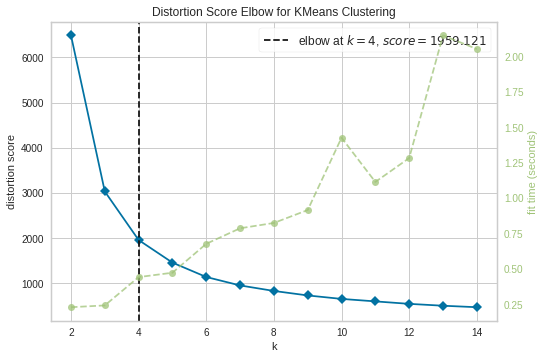

In [25]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(df_new)
visualizer.show()
plt.show()

In [33]:
n_clust = 4
km = KMeans(n_clusters=n_clust,random_state=7,init='k-means++') 
km.fit(df_new) 

info_df['KMeans_clust'] = km.labels_

list_of_centers = km.cluster_centers_[:,1].tolist()

In [34]:
info_df.KMeans_clust.value_counts()

0    62781
1    24468
2    19221
3     9559
Name: KMeans_clust, dtype: int64

In [36]:
info_df[info_df['active'] == 'BTCUSDT'].KMeans_clust.value_counts()

0    3981
3    1742
2    1204
1     361
Name: KMeans_clust, dtype: int64

<AxesSubplot:xlabel='open_scaled', ylabel='close_scaled'>

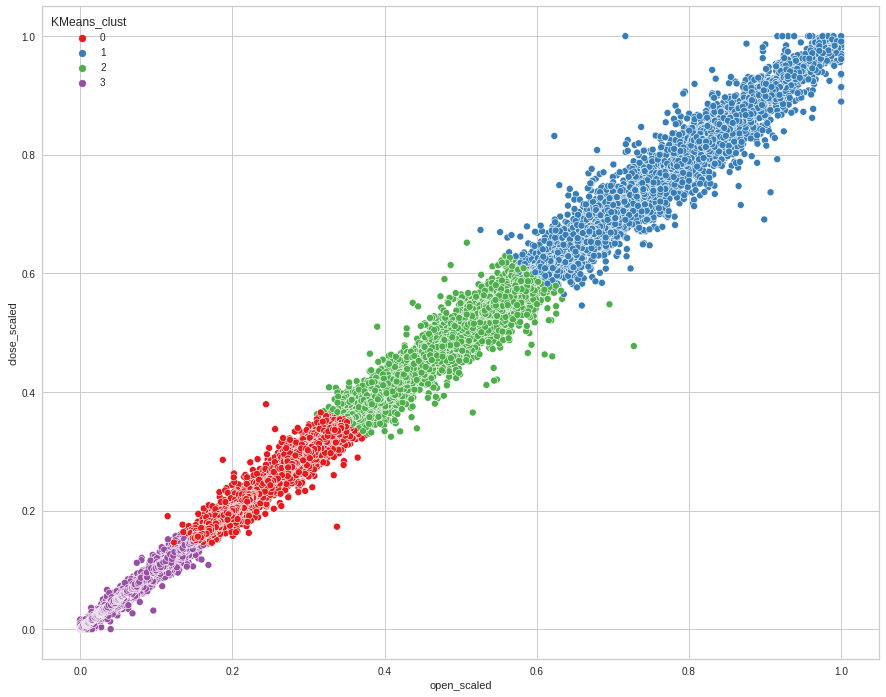

In [30]:
from matplotlib.pyplot import figure
figure(figsize=(15, 12))
sns.scatterplot('open_scaled', 'close_scaled', data=df_new,
            hue='KMeans_clust', palette='Set1', legend='full')

In [ ]:
scaler = MinMaxScaler()
i = 0
for active in set(df.active):
    
    df_aux = df_filtered[df_filtered.active == active]
    df_aux['close_scaled'] = scaler.fit_transform(df_aux['close'].values.reshape(-1, 1))
    if i == 0:
        df_final_scaled = df_aux.copy()
        i += 1
    else:
        df_final_scaled = pd.concat([df_final_scaled, df_aux])

df_final_scaled

In [22]:
def clustering(data, symbols, clustering_method='tskmeans_euclidean', scaler='minmax', n_clusters=2):
    only_close = len(data.shape)==2
    
    if (scaler == 'minmax'):
        scaler = TimeSeriesScalerMinMax()
        data_scaled = scaler.fit_transform(data)
    elif(scaler == 'standart'):
        scaler = TimeSeriesScalerMeanVariance()
        data_scaled = scaler.fit_transform()
    else:
        print("uncorrect scaler")
        return 0
    
    if (clustering_method=='tskmeans_euclidean'):
        clusterer = TimeSeriesKMeans(n_clusters, n_init=100, metric='euclidean', n_jobs=-1)
    elif (clustering_method=='kmeans'):
        if (not(only_close)):
            data_scaled = data_scaled.swapaxes(2, 1).reshape(data_scaled.shape[0], -1)
        clusterer = KMeans(n_init=100, n_clusters=n_clusters)

    clusterer.fit(data_scaled)
    clusters = clusterer.predict(data_scaled)
    clusters_names = ['Clusters without BTC', 'Clusters without BTC']
    clusters_names[clusters[np.where(symbols=='BTCUSDT')[0][0]]] = 'Cluster with BTC'

    for cluster_number in range(n_clusters):
        print(f"Cluster name: {clusters_names[cluster_number]}") 

        if (only_close == False):
            plot_cluster_tickers(data[(clusters == cluster_number).nonzero(), :, 0][0, :, :], symbols[(clusters == cluster_number).nonzero()])
        else:
            plot_cluster_tickers(data[(clusters == cluster_number).nonzero()], symbols[(clusters==cluster_number).nonzero()])
    
    return data_scaled, symbols, clusters

In [23]:
activos = set(list(df.active))

In [ ]:
scaler = TimeSeriesScalerMinMax()
data_scaled = scaler.fit_transform(data)
df['close_scaled'] = scaler.fit_transform(df.groupby(['active'], as_index=False)['close']

In [29]:
df.groupby(['active'], as_index=False)['close']

In [27]:
coins_scaled_flattened, symbols, clasters_kmeans = clustering(df[columns], activos)

IndexError: index 0 is out of bounds for axis 0 with size 0

### Load Data

In [7]:
coins, symbols, timesteps = coins_data_USDT('10 Aug, 2021', '18 Oct, 2021', Client.KLINE_INTERVAL_1HOUR, only_close=False)


KeyboardInterrupt

